Calculate the Bayes Factor for $u-r$ to determine whether the void and wall samples are drawn from the same or different parent distributions.

In [39]:
from astropy.table import Table
from astropy.io import fits

import numpy as np

import sys

import pickle

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

import matplotlib
import matplotlib.pyplot as plt

from functions import Model_1_plot, Model_2_plot, uniform, jeffreys, Model_1_fit, Model_2_fit, Model_1_sampler, Model_2_sampler
#from functions_gauss import Model_1_fit, Model_2_fit, Model_1_sampler, Model_2_sampler

np.set_printoptions(threshold=sys.maxsize)

In [2]:
matplotlib.rc('font', size=14)
matplotlib.rc('font', family='DejaVu Sans')

# Data

In [3]:
data_filename = '../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF.fits'

hdu = fits.open(data_filename)
data = Table(hdu[1].data)
hdu.close()

## Just keep the main SDSS DR7 footprint

In [4]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]

In [5]:
ur_NSA = np.array(catalog_main['u_r'])

## Separate galaxies by their LSS classifications

### $V^2$

In [6]:
wall_v2 = catalog_main['vflag_V2'] == 0
void_v2 = catalog_main['vflag_V2'] == 1
edge_v2 = catalog_main['vflag_V2'] == 2
out_v2 = catalog_main['vflag_V2'] == 9

### VoidFinder

In [7]:
wall_vf = catalog_main['vflag_VF'] == 0
void_vf = catalog_main['vflag_VF'] == 1
edge_vf = catalog_main['vflag_VF'] == 2
out_vf = catalog_main['vflag_VF'] == 9

# Fit the distributions with skewnormal distributions

Both one- and two-parent models

## $u-r$

This is a bimodal distribution

In [20]:
#ur_bins = np.linspace(0, 4, 170)
ur_bins = np.arange(0.5, 4, 0.05)

### 1-parent model

In [21]:
ur_fit_bounds1 = [[0.1, 10],    # s ........ Gaussian 1 to 2 scale factor
                  [100, 10000], # a ........ Gaussian a amplitude
                  [1, 2.1],     # mu_a ..... Gaussian a location
                  [1e-5, 2],    # sigma_a .. Gaussian a scale
                  [-10, 10],      # skew_a ... Gaussian a skew
                  [500, 10000], # b ........ Gaussian b amplitude
                  [2.1, 3.5],   # mu_b ..... Gaussian b location
                  [1e-5, 1],    # sigma_b .. Gaussian b scale
                  [-10, 10]]      # skew_b ... Gaussian b skew

V2_ur_bestfit1 = Model_1_fit(ur_fit_bounds1, 
                             ur_NSA[wall_v2], 
                             ur_NSA[void_v2], 
                             ur_bins, 
                             2)

VF_ur_bestfit1 = Model_1_fit(ur_fit_bounds1, 
                             ur_NSA[wall_vf], 
                             ur_NSA[void_vf], 
                             ur_bins, 
                             2)

running minimizer...this might take a few minutes...
running minimizer...this might take a few minutes...


In [22]:
V2_ur_bestfit1

      fun: 1253.900791964447
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.36627785e-01, -4.00181901e-03, -5.94361612e+00, -5.79232162e+00,
        8.54925025e-03,  2.13733515e-03,  3.78577172e-02, -1.72387900e+00,
       -8.59699863e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 3270
      nit: 233
     njev: 327
   status: 0
  success: True
        x: array([ 2.40893327e+00,  3.69290495e+03,  1.38821425e+00,  7.50634278e-01,
        2.03944847e+00,  1.38638275e+03,  2.72822293e+00,  2.24537254e-01,
       -6.68773376e-01])

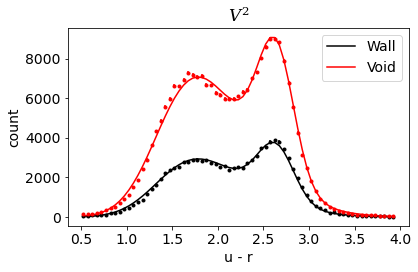

In [23]:
Model_1_plot(V2_ur_bestfit1.x, 
             ur_NSA[wall_v2], 
             ur_NSA[void_v2], 
             ur_bins, 
             2, 
             xlabel_text='u - r', 
             title_text='$V^2$')

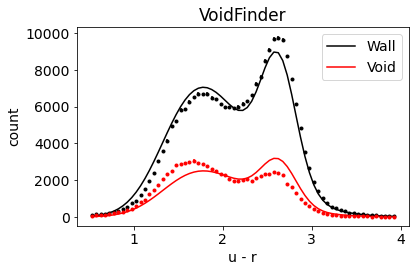

In [24]:
Model_1_plot(VF_ur_bestfit1.x, 
             ur_NSA[wall_vf], 
             ur_NSA[void_vf], 
             ur_bins, 
             2, 
             xlabel_text='u - r', 
             title_text='VoidFinder')

In [25]:
VF_ur_bestfit1

      fun: 4775.685427481214
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.03001333, -0.0034558 ,  0.00627551,  0.11723387, -0.54278644,
        0.00245566, -0.08258212,  0.01791705, -0.01082299])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2630
      nit: 180
     njev: 263
   status: 0
  success: True
        x: array([3.54963993e-01, 8.80590317e+03, 1.38892292e+00, 7.43192433e-01,
       2.02904975e+00, 3.27114944e+03, 2.62712085e+00, 1.98718258e-01,
       1.16214320e-02])

#### Nested sampling of Likelihood and Priors

##### V$^2$

In [31]:
def prior_xform1_bi_V2(u):
    '''
    Priors for the 9 parameters of bimodel M1.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    s = uniform(0.1, 10, u[0])
    
    a = jeffreys(500, 5000, u[1])
    mu_a = uniform(1, 2.1, u[2])
    sigma_a = uniform(0.1, 3, u[3])
    skew_a = uniform(0, 5, u[4])
    
    b = jeffreys(100, 5000, u[5])
    mu_b = uniform(2.1, 3.5, u[6])
    sigma_b = uniform(0.001, 3, u[7])
    skew_b = uniform(-5, 0, u[8])

    return s, a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b

In [32]:
Model_1_sampler(prior_xform1_bi_V2, 
                ur_NSA[wall_v2], 
                ur_NSA[void_v2], 
                ur_bins, 
                2, 
                '_ur_V2')

running the nested sampler... this might take from minutes to hours...


40487it [09:45, 69.12it/s, batch: 7 | bound: 437 | nc: 10 | ncall: 373961 | eff(%): 10.827 | loglstar: -1263.380 < -1254.188 < -1256.009 | logz: -1303.171 +/-  0.415 | stop:  0.839]       


sampler output saved as pickle file 'dynesty_output/sampler_results_model1_ur_V2'


In [33]:
temp_infile = open('dynesty_output/sampler_results_model1_ur_V2.pickle', 'rb')
dres1_V2_ur = pickle.load(temp_infile)
temp_infile.close()

In [34]:
labels1_bi = ['s', 'a', r'$\mu_a$', r'$\sigma_a$', 'skew$_a$', 
                   'b', r'$\mu_b$', r'$\sigma_b$', 'skew$_b$']
labels2_bi = ['$a_1$', r'$\mu_{1a}$', r'$\sigma_{1a}$', 'skew$_{1a}$', 
              '$b_1$', r'$\mu_{1b}$', r'$\sigma_{1b}$', 'skew$_{1b}$', 
              '$a_2$', r'$\mu_{2a}$', r'$\sigma_{2a}$', 'skew$_{2a}$', 
              '$b_2$', r'$\mu_{2b}$', r'$\sigma_{2b}$', 'skew$_{2b}$']

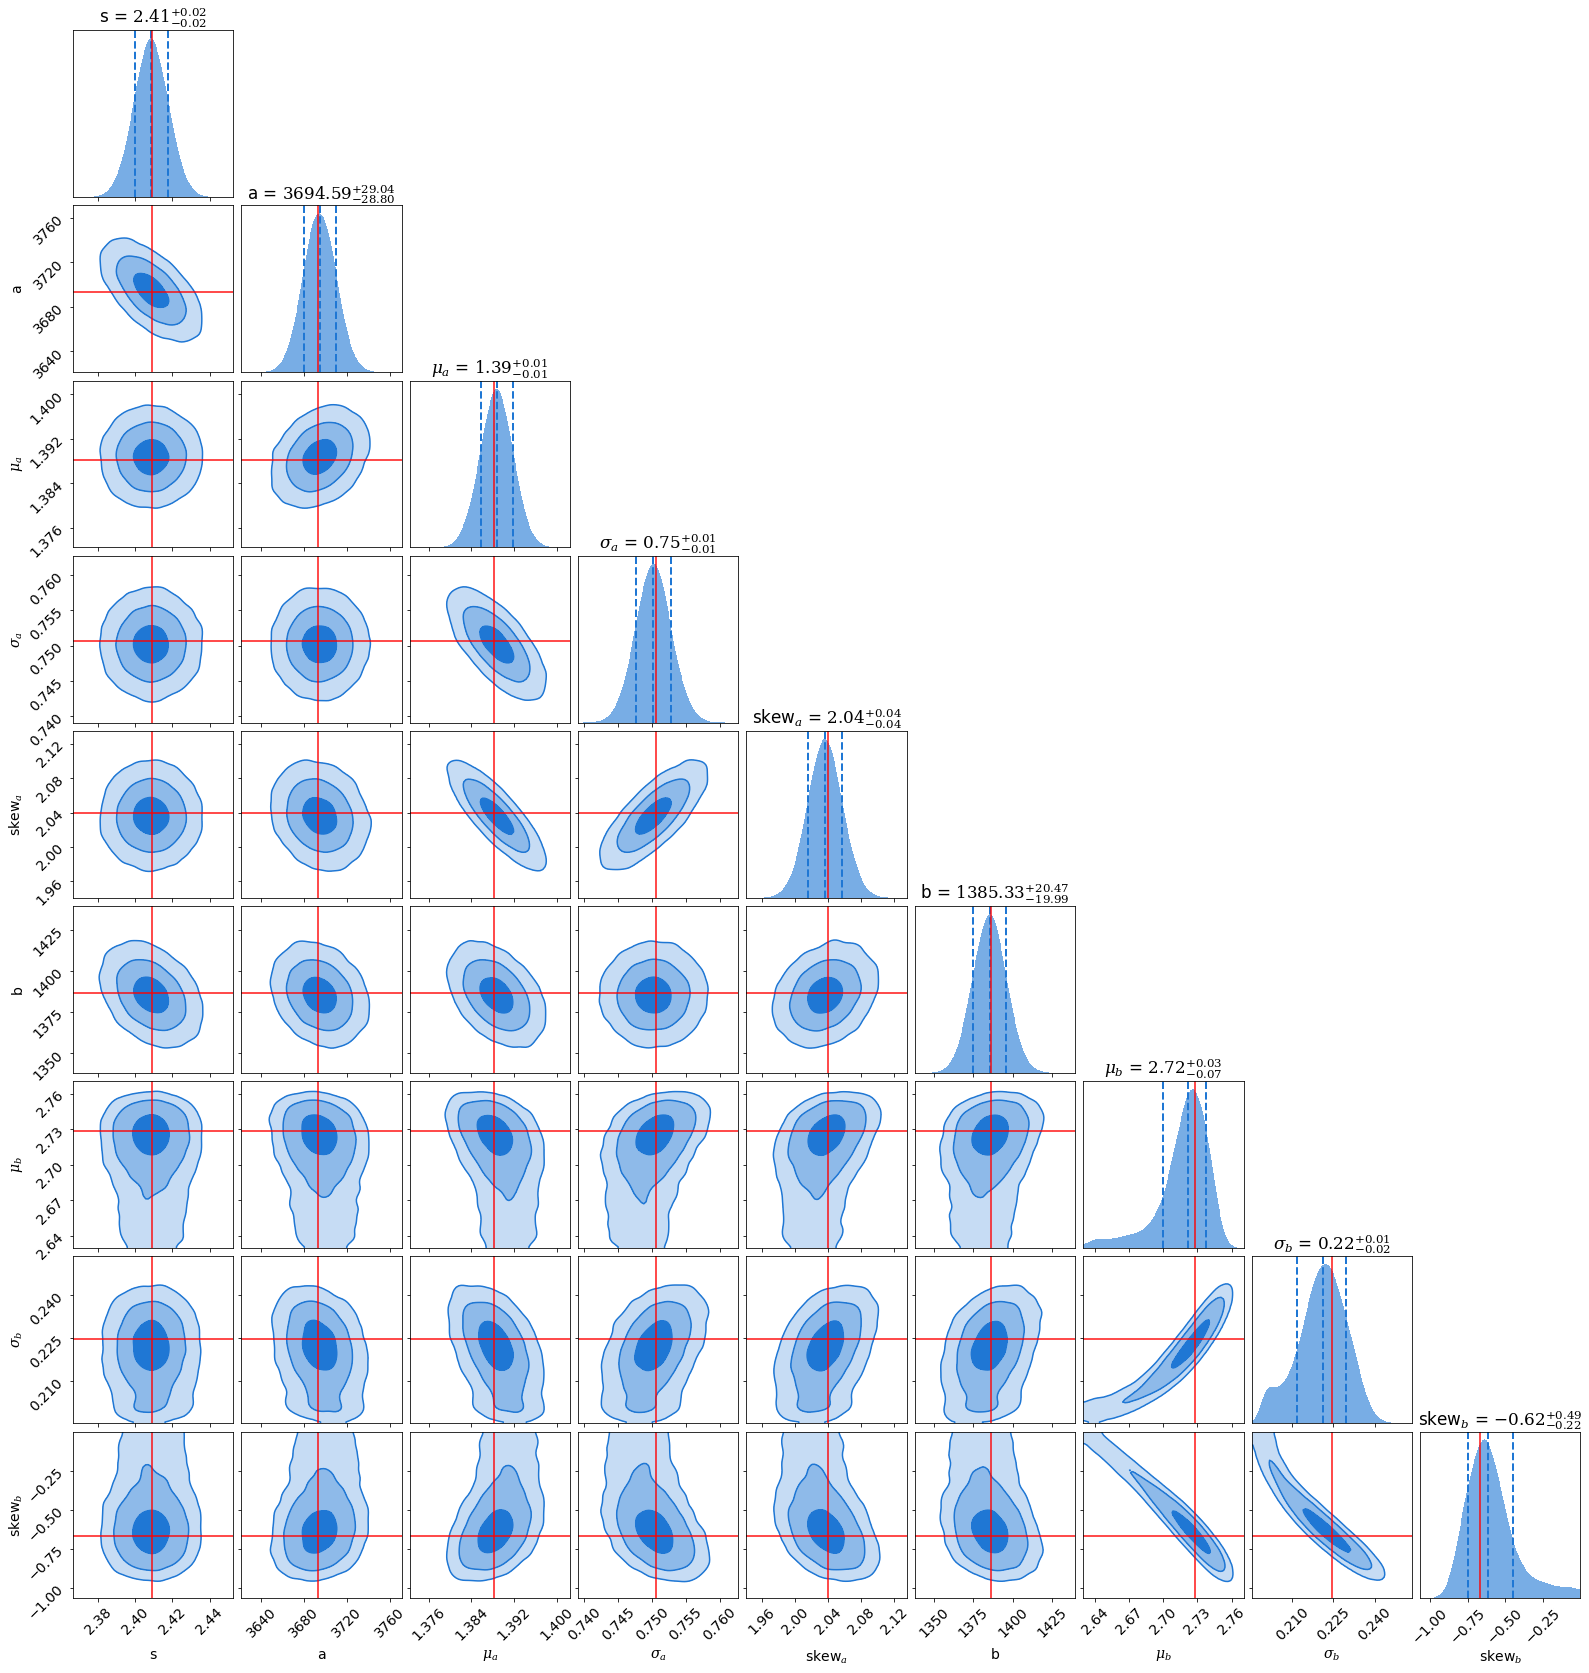

In [35]:
n_params = len(labels1_bi)

fig, axes = dyplot.cornerplot(dres1_V2_ur, smooth=0.03, 
                              labels=labels1_bi, 
                              truths=V2_ur_bestfit1.x,
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(n_params, n_params, figsize=(2.5*n_params, 2.6*n_params)), 
                              color='#1f77d4')

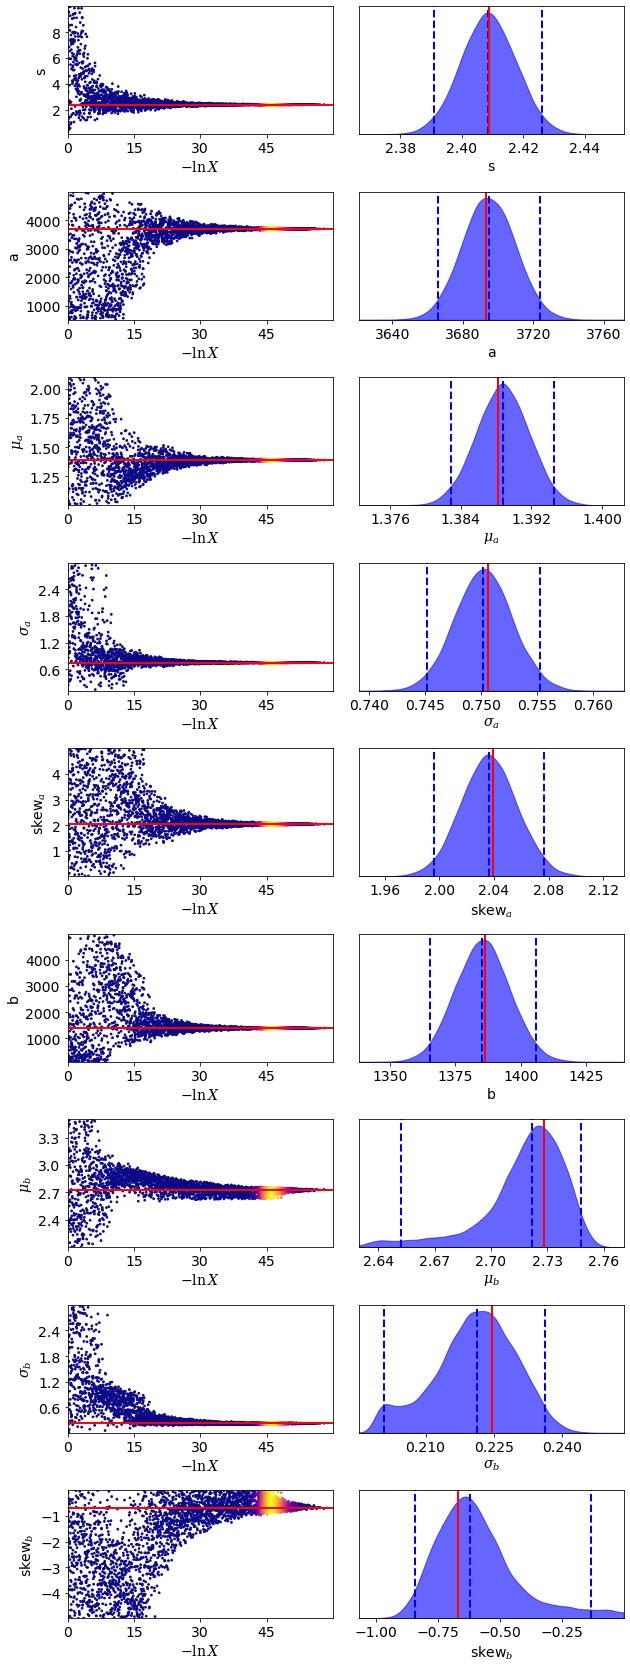

In [36]:
n_params = len(labels1_bi)

fig, axes = dyplot.traceplot(dres1_V2_ur, 
                             labels=labels1_bi, 
                             truths=V2_ur_bestfit1.x,
                             fig=plt.subplots(n_params, 2, figsize=(n_params, 2.6*n_params)), 
                             thin=10)

fig.tight_layout();

In [37]:
lnzM1_V2_ur = dres1_V2_ur.logz[-1]
lnzM1_V2_ur

-1303.1681428575446

In [40]:
V2_ur_bestfit1_dynesty,_ = dyfunc.mean_and_cov(dres1_V2_ur.samples, 
                                               np.exp(dres1_V2_ur.logwt - lnzM1_V2_ur))

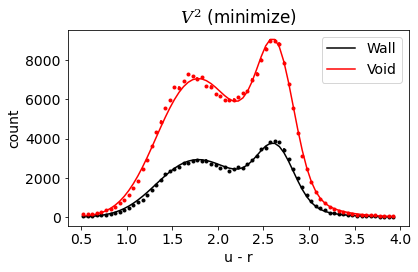

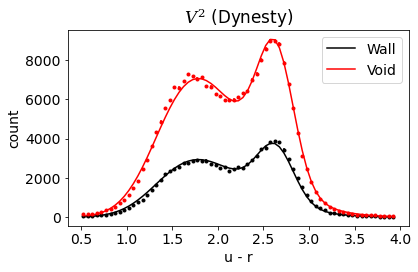

In [41]:
Model_1_plot(V2_ur_bestfit1.x, 
             ur_NSA[wall_v2], 
             ur_NSA[void_v2], 
             ur_bins, 
             2, 
             xlabel_text='u - r', 
             title_text='$V^2$ (minimize)')

Model_1_plot(V2_ur_bestfit1_dynesty, 
             ur_NSA[wall_v2], 
             ur_NSA[void_v2], 
             ur_bins, 
             2, 
             xlabel_text='u - r', 
             title_text='$V^2$ (Dynesty)')

##### VoidFinder

In [42]:
def prior_xform1_bi_VF(u):
    '''
    Priors for the 9 parameters of bimodel M1.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    s = uniform(0.1, 5, u[0])
    
    a = jeffreys(1000, 10000, u[1])
    mu_a = uniform(1, 2.1, u[2])
    sigma_a = uniform(0.1, 3, u[3])
    skew_a = uniform(0, 5, u[4])
    
    b = jeffreys(100, 5000, u[5])
    mu_b = uniform(2.1, 3.5, u[6])
    sigma_b = uniform(0.001, 2, u[7])
    skew_b = uniform(-5, 5, u[8])

    return s, a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b

In [43]:
Model_1_sampler(prior_xform1_bi_VF, 
                ur_NSA[wall_vf], 
                ur_NSA[void_vf], 
                ur_bins, 
                2, 
                '_ur_VoidFinder')

running the nested sampler... this might take from minutes to hours...


40343it [41:00, 16.40it/s, batch: 6 | bound: 3725 | nc: 27 | ncall: 3013751 | eff(%):  1.339 | loglstar: -4782.337 < -4773.321 < -4775.811 | logz: -4822.733 +/-  0.418 | stop:  0.841]       


sampler output saved as pickle file 'dynesty_output/sampler_results_model1_ur_VoidFinder'


In [47]:
temp_infile = open('dynesty_output/sampler_results_model1_ur_VoidFinder.pickle', 'rb')
dres1_VF_ur = pickle.load(temp_infile)
temp_infile.close()

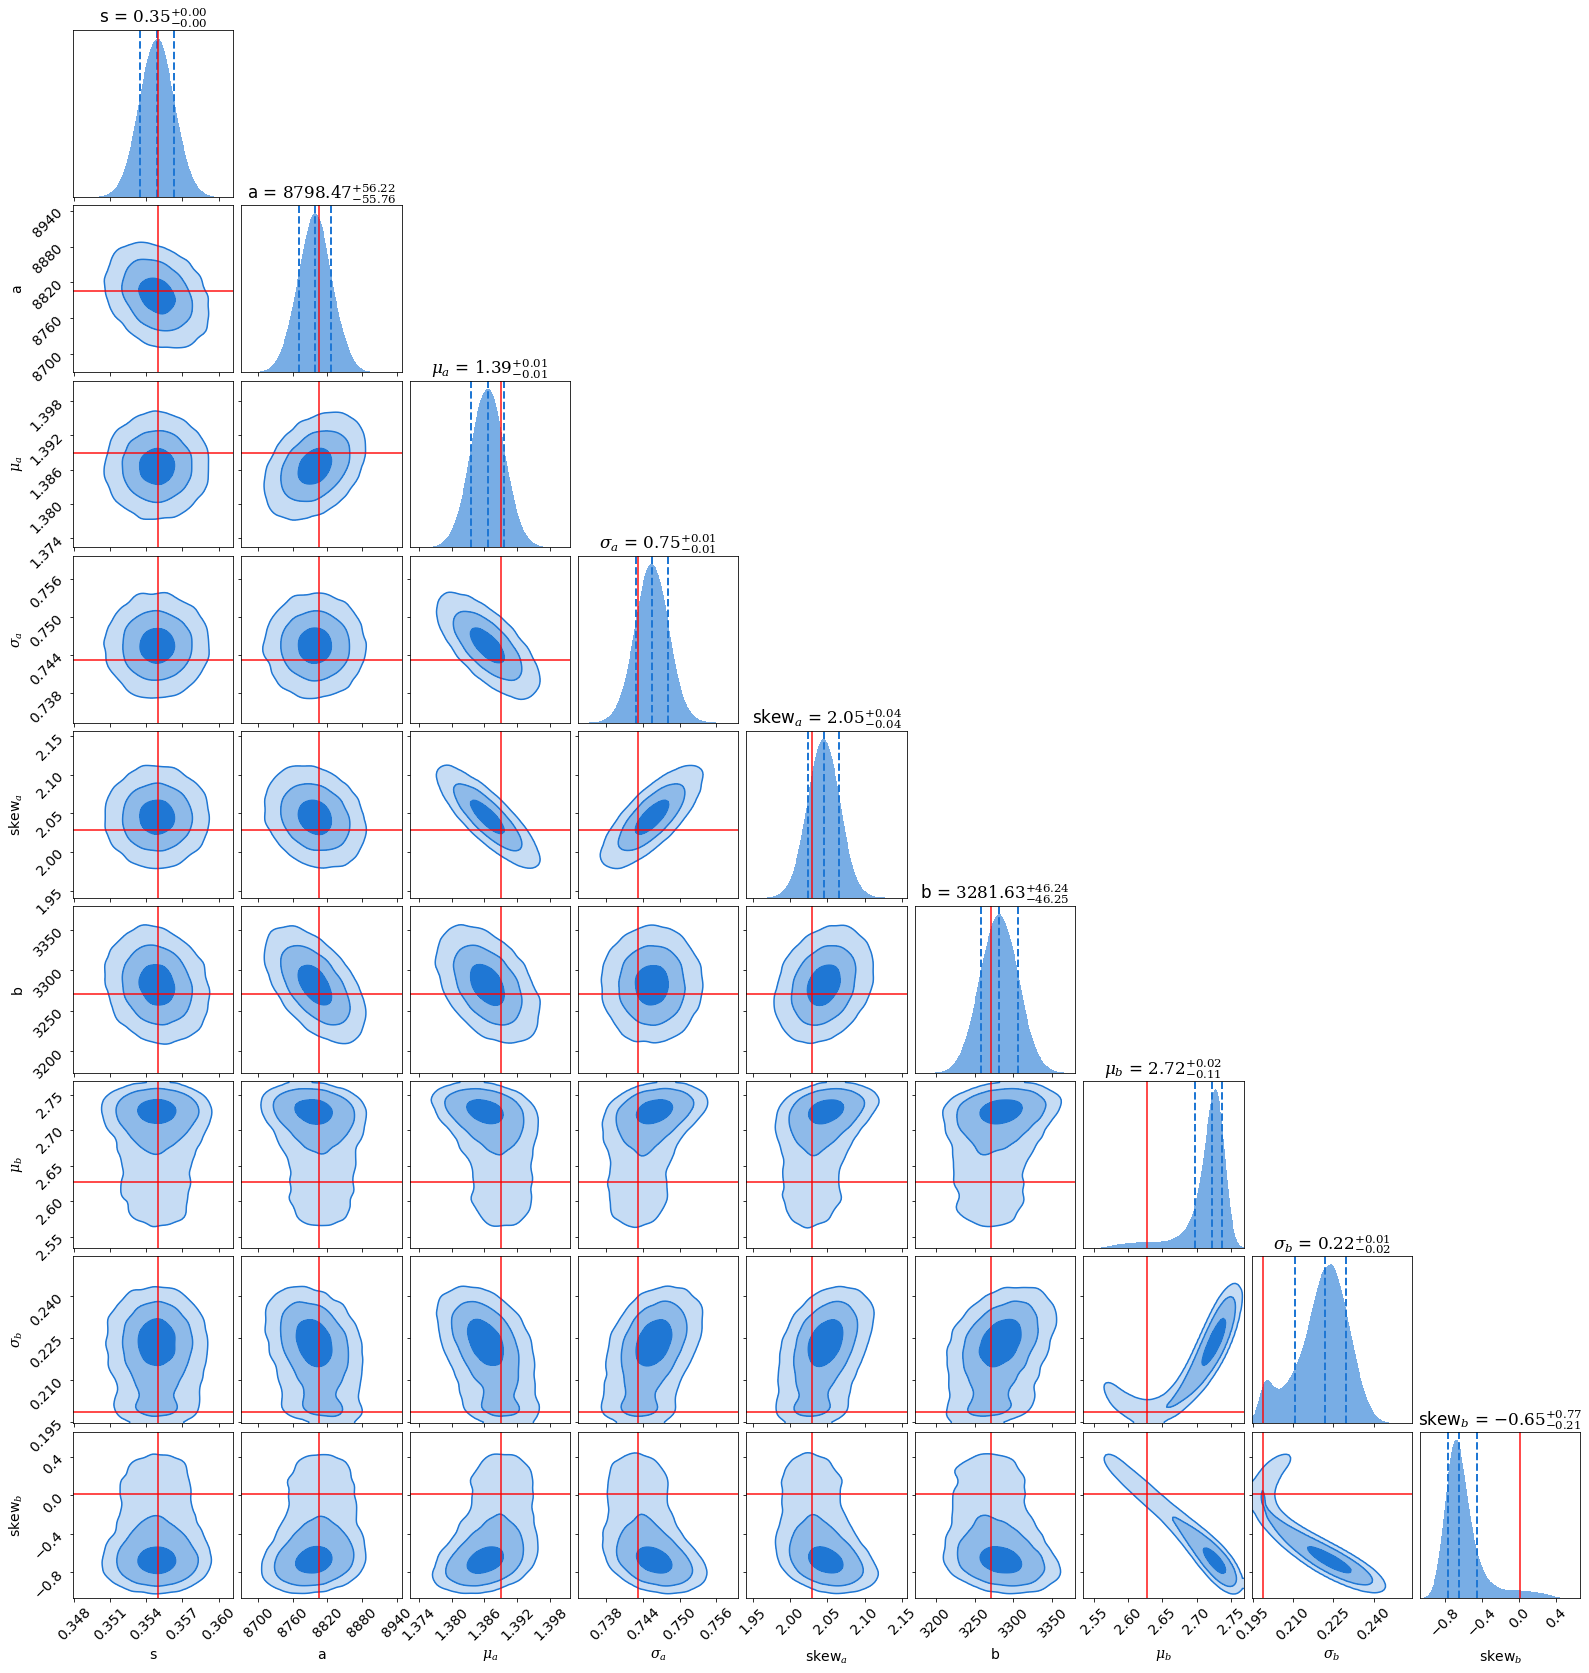

In [48]:
n_params = len(labels1_bi)

fig, axes = dyplot.cornerplot(dres1_VF_ur, smooth=0.03, 
                              labels=labels1_bi, 
                              truths=VF_ur_bestfit1.x,
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(n_params, n_params, figsize=(2.5*n_params, 2.6*n_params)), 
                              color='#1f77d4')

In [49]:
lnzM1_VF_ur = dres1_VF_ur.logz[-1]
lnzM1_VF_ur

-4822.731347962

In [50]:
VF_ur_bestfit1_dynesty,_ = dyfunc.mean_and_cov(dres1_VF_ur.samples, 
                                               np.exp(dres1_VF_ur.logwt - lnzM1_VF_ur))

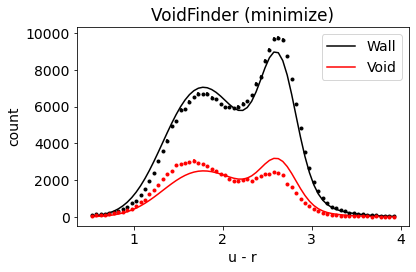

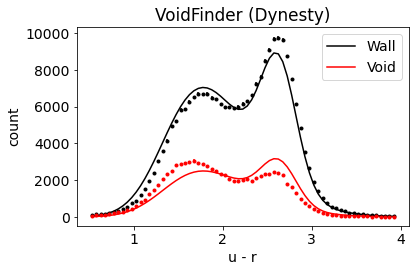

In [51]:
Model_1_plot(VF_ur_bestfit1.x, 
             ur_NSA[wall_vf], 
             ur_NSA[void_vf], 
             ur_bins, 
             2, 
             xlabel_text='u - r', 
             title_text='VoidFinder (minimize)')

Model_1_plot(VF_ur_bestfit1_dynesty, 
             ur_NSA[wall_vf], 
             ur_NSA[void_vf], 
             ur_bins, 
             2, 
             xlabel_text='u - r', 
             title_text='VoidFinder (Dynesty)')

### 2-parent model

In [52]:
# 1 = wall, 2 = void

ur_fit_bounds2 = [[100, 5000],  # a1 ........ Gaussian A1 amplitude
                  [0, 2.1],     # mu_a1 ..... Gaussian A1 location
                  [0.1, 40],    # sigma_a1 .. Gaussian A1 scale
                  [-5, 5],     # skew_a1 ... Gaussian A1 skew
                  [500, 10000], # b1 ........ Gaussian B1 amplitude
                  [2.1, 3.5],   # mu_b1 ..... Gaussian B1 location
                  [0.1, 3],     # sigma_b1 .. Gaussian B1 scale
                  [-10, 10],    # skew_b1 ... Gaussian B1 skew
                  [500, 10000], # a2 ........ Gaussian A2 amplitude
                  [1, 2.1],     # mu_a2 ..... Gaussian A2 location
                  [0.1, 3],     # sigma_a2 .. Gaussian A2 scale
                  [0, 5],       # skew_a2 ... Gaussian A2 skew
                  [500, 10000], # b2 ........ Gaussian B2 amplitude
                  [2.1, 3.5],   # mu_b2 ..... Gaussian B2 location
                  [0.1, 3],     # sigma_b2 .. Gaussian B2 scale
                  [-10, 5]]      # skew_b2 ... Gaussian B2 skew

V2_ur_bestfit2 = Model_2_fit(ur_fit_bounds2, 
                             ur_NSA[wall_v2], 
                             ur_NSA[void_v2], 
                             ur_bins, 
                             2)

running minimizer...this might take a few minutes...


In [53]:
V2_ur_bestfit2

      fun: 1505.5171254061033
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.17364711,  0.2750312 , -0.33282958,  0.0794671 ,  0.16170987,
        0.22553195,  0.46070454, -0.02428351, -0.32546612, -0.3301011 ,
       -1.42929365, -0.29240255,  0.45052296,  0.89476089, -1.32451987,
       -0.5262109 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 7123
      nit: 357
     njev: 419
   status: 0
  success: True
        x: array([ 3.72093481e+03,  1.40888289e+00,  7.55790552e-01,  1.95785889e+00,
        1.40298276e+03,  2.69807679e+00,  2.06544928e-01, -3.82784640e-01,
        8.10138992e+03,  1.33341035e+00,  7.50041911e-01,  2.27907211e+00,
        4.09239024e+03,  2.81081523e+00,  3.32078647e-01, -1.64944306e+00])

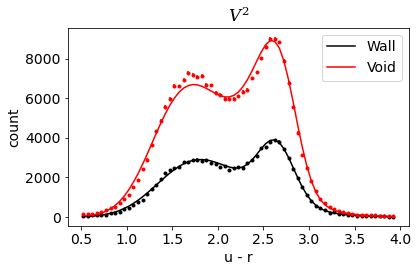

In [54]:
Model_2_plot(V2_ur_bestfit2.x, 
             ur_NSA[wall_v2], 
             ur_NSA[void_v2], 
             ur_bins, 
             2, 
             xlabel_text='u - r', 
             title_text='$V^2$')

In [66]:
# 1 = wall, 2 = void

ur_fit_bounds2 = [[500, 10000], # a1 ........ Gaussian A1 amplitude
                  [0, 2.1],     # mu_a1 ..... Gaussian A1 location
                  [0.001, 3],   # sigma_a1 .. Gaussian A1 scale
                  [0, 10],      # skew_a1 ... Gaussian A1 skew
                  [100, 10000], # b1 ........ Gaussian B1 amplitude
                  [2.1, 3.5],   # mu_b1 ..... Gaussian B1 location
                  [0.001, 3],   # sigma_b1 .. Gaussian B1 scale
                  [-5, 5],      # skew_b1 ... Gaussian B1 skew
                  [500, 10000], # a2 ........ Gaussian A2 amplitude
                  [1, 2.1],     # mu_a2 ..... Gaussian A2 location
                  [0.001, 3],   # sigma_a2 .. Gaussian A2 scale
                  [0, 5],       # skew_a2 ... Gaussian A2 skew
                  [100, 5000],  # b2 ........ Gaussian B2 amplitude
                  [2.1, 3.5],   # mu_b2 ..... Gaussian B2 location
                  [0.001, 3],   # sigma_b2 .. Gaussian B2 scale
                  [-10, 5]]      # skew_b2 ... Gaussian B2 skew

VF_ur_bestfit2 = Model_2_fit(ur_fit_bounds2, 
                             ur_NSA[wall_vf], 
                             ur_NSA[void_vf], 
                             ur_bins, 
                             2)

running minimizer...this might take a few minutes...


In [67]:
VF_ur_bestfit2

      fun: 1435.1603692592917
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.45231924,  4.20905056,  5.30706072, -1.11238024, -0.05811733,
        1.19621291, -8.63617516, -0.04790763, -0.91834925, -1.57178875,
       -0.59335434,  0.32646313,  0.05259149,  2.07182894, -0.86013188,
       -0.73307547])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 11101
      nit: 558
     njev: 653
   status: 0
  success: True
        x: array([ 7.94559932e+03,  1.39992632e+00,  7.49211049e-01,  2.11081062e+00,
        3.94423622e+03,  2.78217288e+00,  2.72549656e-01, -1.19101660e+00,
        3.17016025e+03,  1.28944732e+00,  7.07778330e-01,  2.16258471e+00,
        9.72785792e+02,  2.74810506e+00,  2.88545389e-01, -1.10218903e+00])

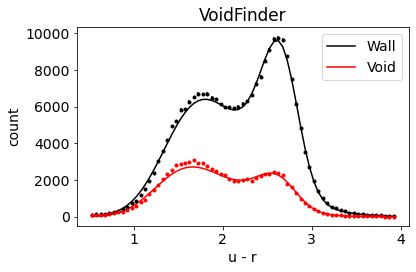

In [68]:
Model_2_plot(VF_ur_bestfit2.x, 
             ur_NSA[wall_vf], 
             ur_NSA[void_vf], 
             ur_bins, 
             2, 
             xlabel_text='u - r', 
             title_text='VoidFinder')

#### Nested sampling of Likelihood and Priors

##### V$^2$

In [79]:
def prior_xform2_bi_V2(u):
    '''
    Priors for the 16 parameters of bimodal M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a1 = jeffreys(500, 10000, u[0])
    mu_a1 = uniform(1, 2.1, u[1])
    sigma_a1 = uniform(0.01, 2, u[2])
    skew_a1 = uniform(-5, 5, u[3])

    b1 = jeffreys(100, 5000, u[4])
    mu_b1 = uniform(2.1, 3.5, u[5])
    sigma_b1 = uniform(0.01, 2, u[6])
    skew_b1 = uniform(-5, 5, u[7])
    
    a2 = jeffreys(1000, 20000, u[8])
    mu_a2 = uniform(1, 2.1, u[9])
    sigma_a2 = uniform(0.01, 2, u[10])
    skew_a2 = uniform(0, 5, u[11])

    b2 = jeffreys(500, 10000, u[12])
    mu_b2 = uniform(2.1, 3.5, u[13])
    sigma_b2 = uniform(0.01, 2, u[14])
    skew_b2 = uniform(-5, 0, u[15])

    return a1, mu_a1, sigma_a1, skew_a1, b1, mu_b1, sigma_b1, skew_b1, \
           a2, mu_a2, sigma_a2, skew_a2, b2, mu_b2, sigma_b2, skew_b2

In [80]:
Model_2_sampler(prior_xform2_bi_V2, 
                ur_NSA[wall_v2], 
                ur_NSA[void_v2], 
                ur_bins, 
                2, 
                '_ur_V2')

running the nested sampler... this might take from minutes to hours...


11342it [03:27, 54.99it/s, batch: 0 | bound: 139 | nc: 25 | ncall: 259177 | eff(%):  4.368 | loglstar:   -inf < -6752.597 <    inf | logz: -6781.799 +/-  0.337 | dlogz: 2660.879 >  0.010]  /Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
12820it [03:59, 54.96it/s, batch: 0 | bound: 162 | nc: 25 | ncall: 300389 | eff(%):  4.261 | loglstar:   -inf < -5086.844 <    inf | logz: -5118.333 +/-  0.349 | dlogz: 2265.504 >  0.010] /Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:243: UserWarning: Random w

sampler output saved as pickle file 'dynesty_output/sampler_results_model2_ur_V2'


In [81]:
temp_infile = open('dynesty_output/sampler_results_model2_ur_V2.pickle', 'rb')
dres2_V2_ur = pickle.load(temp_infile)
temp_infile.close()

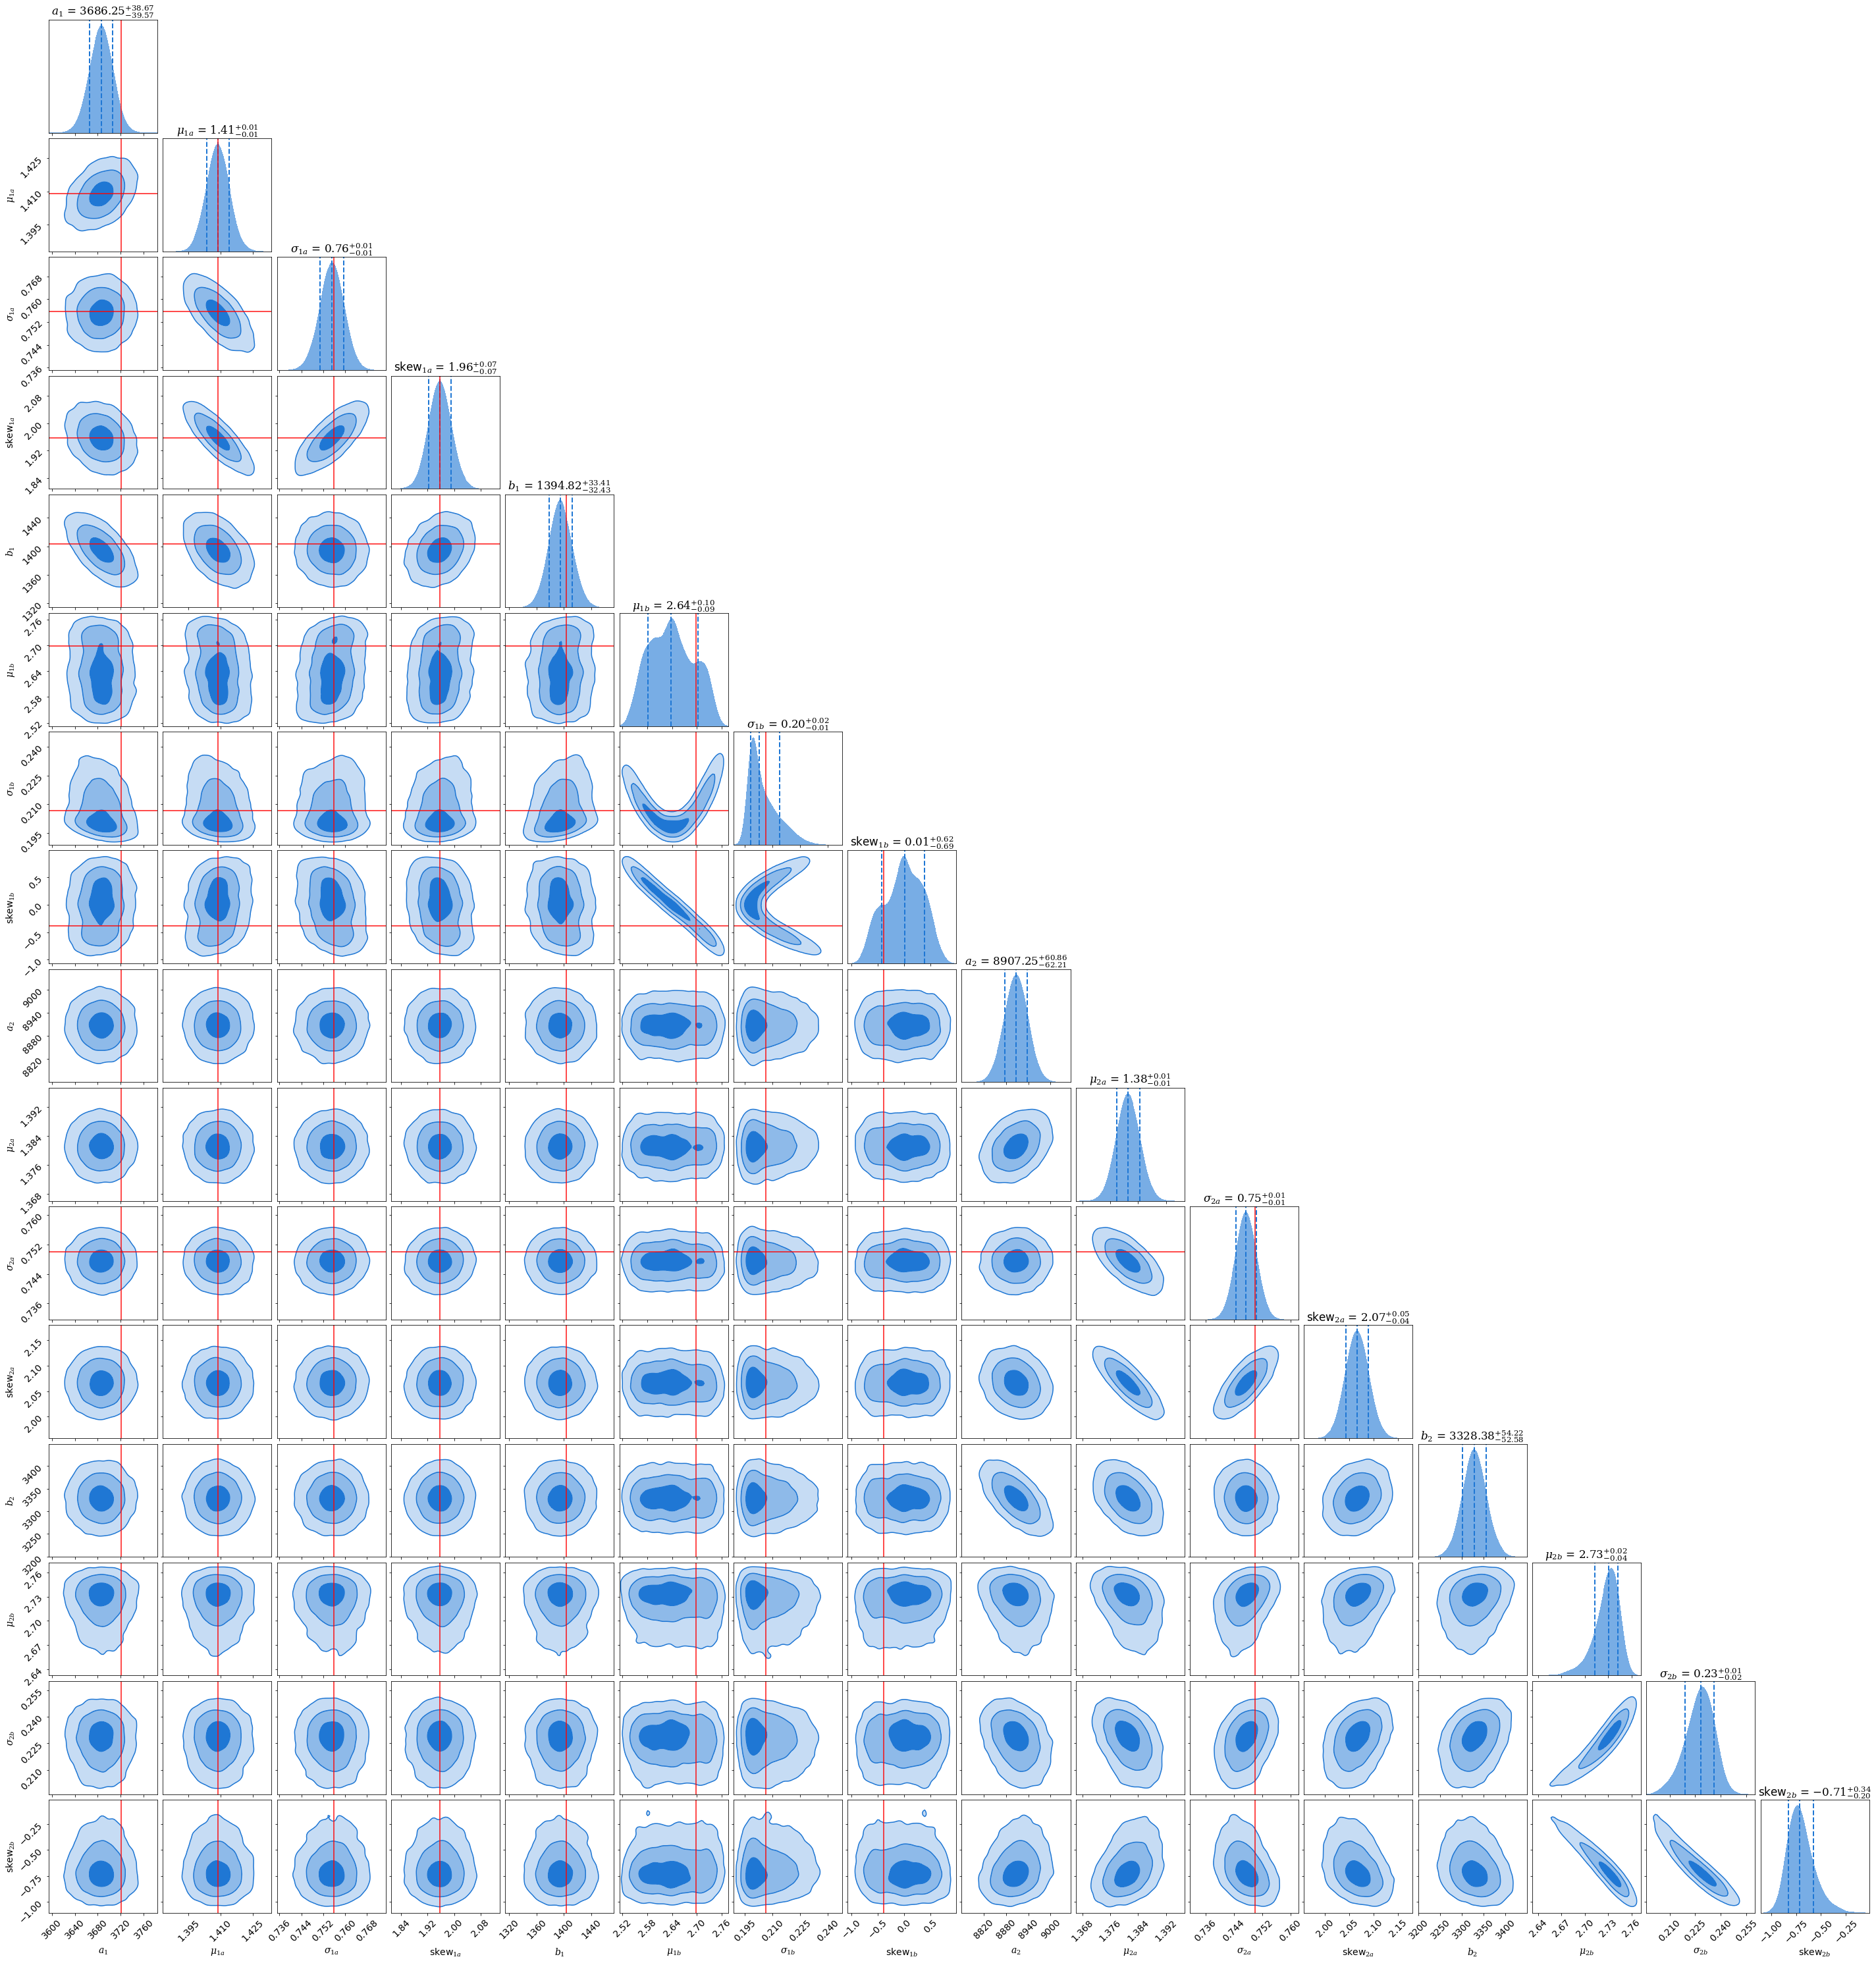

In [82]:
n_params = len(labels2_bi)

fig, axes = dyplot.cornerplot(dres2_V2_ur, smooth=0.03, 
                              labels=labels2_bi, 
                              truths=V2_ur_bestfit2.x,
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(n_params, n_params, figsize=(2.5*n_params, 2.6*n_params)), 
                              color='#1f77d4')

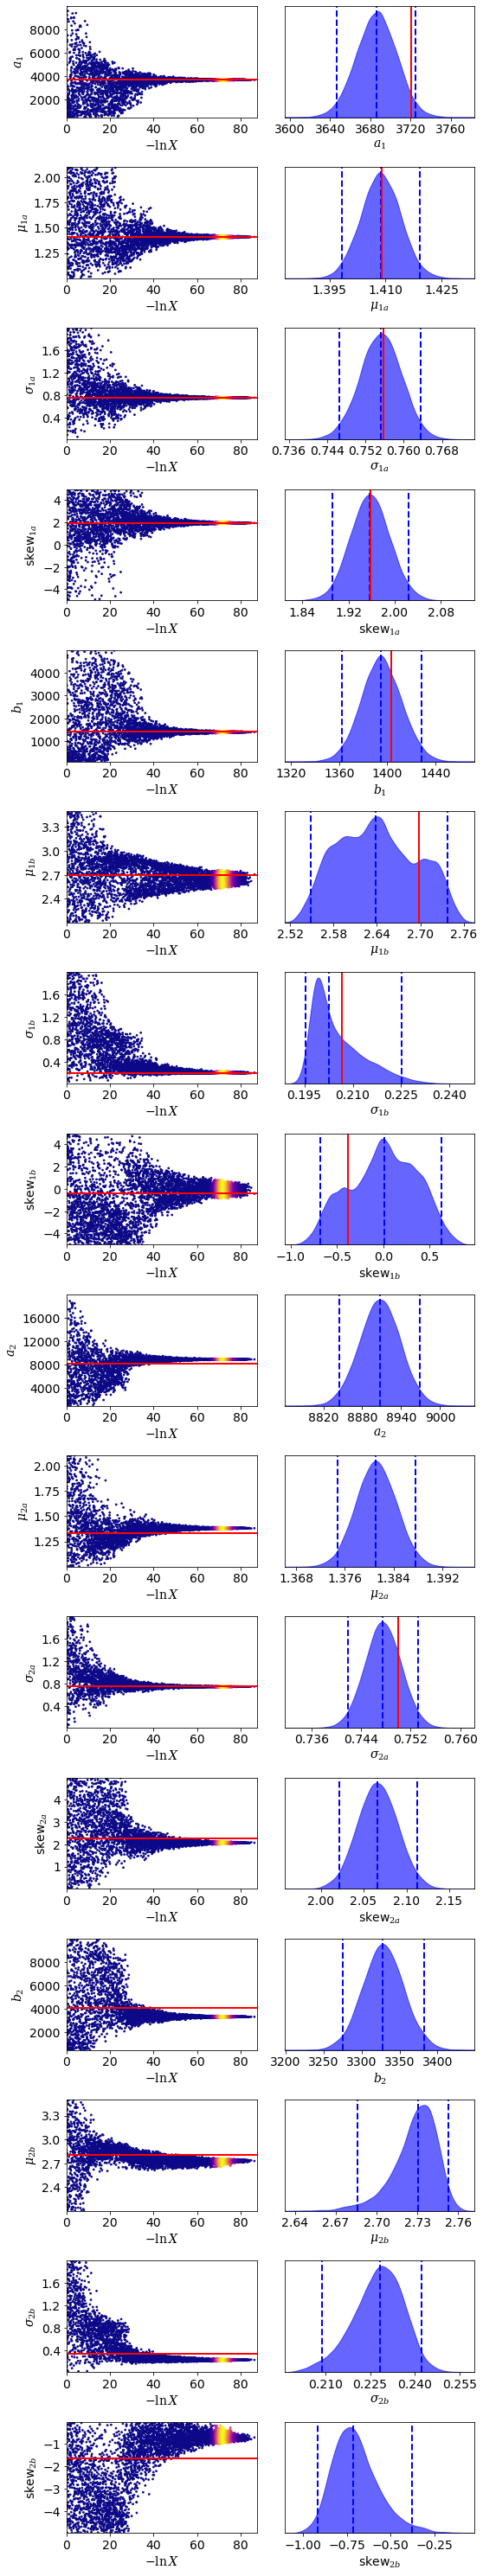

In [83]:
n_params = len(labels2_bi)

fig, axes = dyplot.traceplot(dres2_V2_ur, 
                             labels=labels2_bi, 
                             truths=V2_ur_bestfit2.x,
                             fig=plt.subplots(n_params, 2, figsize=(0.5*n_params, 2.6*n_params)), 
                             thin=10)

fig.tight_layout();

In [84]:
lnzM2_V2_ur = dres2_V2_ur.logz[-1]
lnzM2_V2_ur

-1236.864949723582

In [100]:
V2_ur_bestfit2_dynesty,_ = dyfunc.mean_and_cov(dres2_V2_ur.samples, 
                                               np.exp(dres2_V2_ur.logwt - lnzM2_V2_ur))

V2_ur_bestfit2_dynesty

array([ 3.68597803e+03,  1.40871329e+00,  7.55199369e-01,  1.95738665e+00,
        1.39506856e+03,  2.64010666e+00,  2.05260318e-01, -5.40654204e-03,
        8.90703670e+03,  1.38112831e+00,  7.47501489e-01,  2.06634328e+00,
        3.32860162e+03,  2.72777985e+00,  2.27578066e-01, -6.98066746e-01])

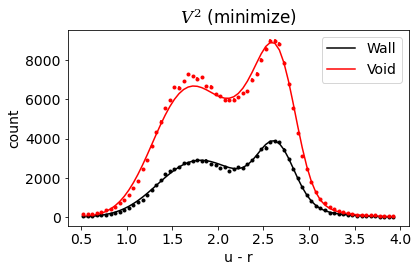

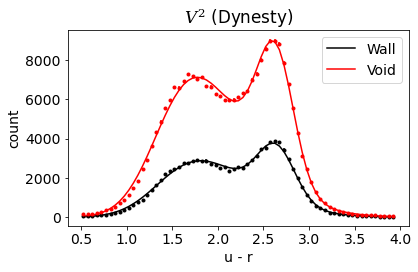

In [86]:
Model_2_plot(V2_ur_bestfit2.x, 
             ur_NSA[wall_v2], 
             ur_NSA[void_v2], 
             ur_bins, 
             2, 
             xlabel_text='u - r', 
             title_text='$V^2$ (minimize)')

Model_2_plot(V2_ur_bestfit2_dynesty, 
             ur_NSA[wall_v2], 
             ur_NSA[void_v2], 
             ur_bins, 
             2, 
             xlabel_text='u - r', 
             title_text='$V^2$ (Dynesty)')

##### VoidFinder

In [92]:
def prior_xform2_bi_VF(u):
    '''
    Priors for the 16 parameters of bimodal M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a1 = jeffreys(1000, 10000, u[0])
    mu_a1 = uniform(1, 2.1, u[1])
    sigma_a1 = uniform(0.01, 2, u[2])
    skew_a1 = uniform(0, 5, u[3])

    b1 = jeffreys(500, 10000, u[4])
    mu_b1 = uniform(2.1, 3.5, u[5])
    sigma_b1 = uniform(0.01, 2, u[6])
    skew_b1 = uniform(-5, 0, u[7])
    
    a2 = jeffreys(500, 10000, u[8])
    mu_a2 = uniform(1, 2.1, u[9])
    sigma_a2 = uniform(0.01, 2, u[10])
    skew_a2 = uniform(0, 5, u[11])

    b2 = jeffreys(100, 5000, u[12])
    mu_b2 = uniform(2.1, 3.5, u[13])
    sigma_b2 = uniform(0.01, 2, u[14])
    skew_b2 = uniform(-5, 5, u[15])

    return a1, mu_a1, sigma_a1, skew_a1, b1, mu_b1, sigma_b1, skew_b1, \
           a2, mu_a2, sigma_a2, skew_a2, b2, mu_b2, sigma_b2, skew_b2

In [93]:
Model_2_sampler(prior_xform2_bi_VF, 
                ur_NSA[wall_vf], 
                ur_NSA[void_vf], 
                ur_bins, 
                2, 
                '_ur_VoidFinder')

running the nested sampler... this might take from minutes to hours...


12230it [03:24, 56.75it/s, batch: 0 | bound: 156 | nc: 25 | ncall: 282488 | eff(%):  4.322 | loglstar:   -inf < -5009.675 <    inf | logz: -5040.893 +/-  0.351 | dlogz: 2073.206 >  0.010]  /Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
13188it [03:48, 60.16it/s, batch: 0 | bound: 177 | nc: 25 | ncall: 317586 | eff(%):  4.146 | loglstar:   -inf < -4223.639 <    inf | logz: -4255.334 +/-  0.352 | dlogz: 1586.637 >  0.010] /Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:221: UserWarning: Random number ge

sampler output saved as pickle file 'dynesty_output/sampler_results_model2_ur_VoidFinder'


In [94]:
temp_infile = open('dynesty_output/sampler_results_model2_ur_VoidFinder.pickle', 'rb')
dres2_VF_ur = pickle.load(temp_infile)
temp_infile.close()

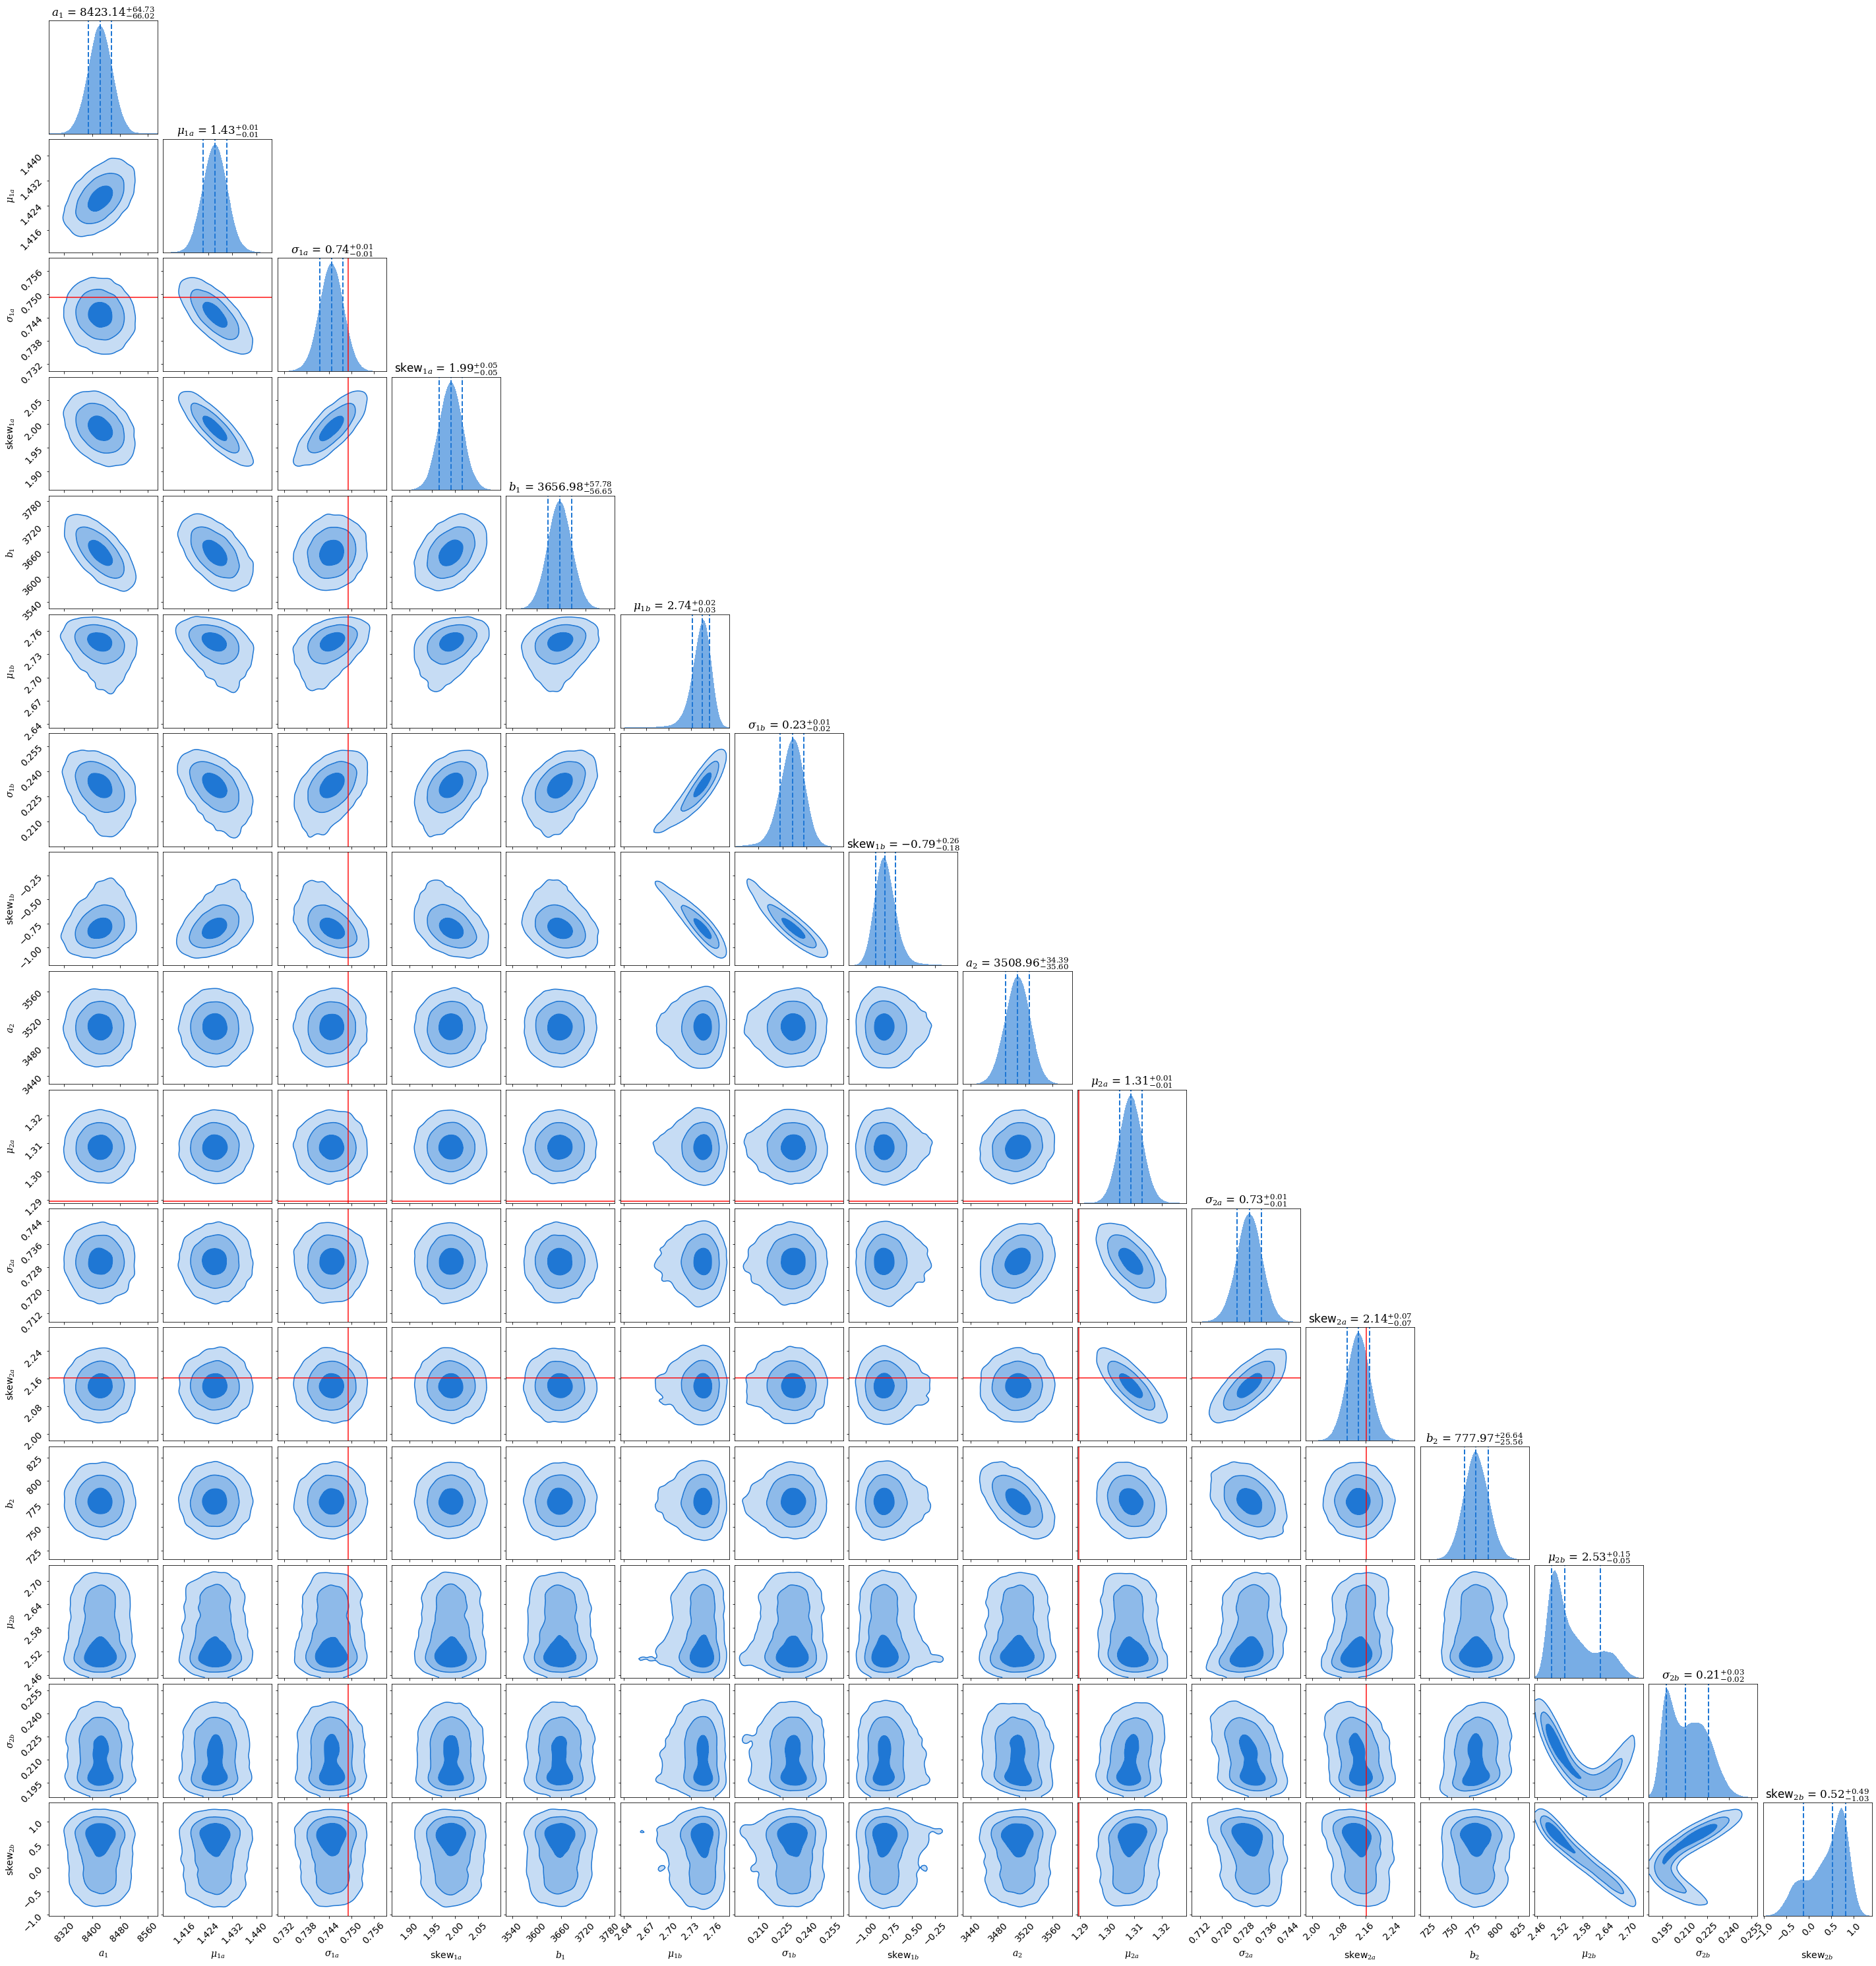

In [95]:
n_params = len(labels2_bi)

fig, axes = dyplot.cornerplot(dres2_VF_ur, smooth=0.03, 
                              labels=labels2_bi, 
                              truths=VF_ur_bestfit2.x,
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(n_params, n_params, figsize=(2.5*n_params, 2.6*n_params)), 
                              color='#1f77d4')

In [96]:
lnzM2_VF_ur = dres2_VF_ur.logz[-1]
lnzM2_VF_ur

-1240.4597709626619

In [101]:
VF_ur_bestfit2_dynesty,_ = dyfunc.mean_and_cov(dres2_VF_ur.samples, 
                                               np.exp(dres2_VF_ur.logwt - lnzM2_VF_ur))

VF_ur_bestfit2_dynesty

array([ 8.42304840e+03,  1.42625480e+00,  7.44721673e-01,  1.99088888e+00,
        3.65725346e+03,  2.74335004e+00,  2.30875725e-01, -7.84145199e-01,
        3.50882866e+03,  1.30871050e+00,  7.29916878e-01,  2.13933530e+00,
        7.78138019e+02,  2.55216711e+00,  2.11541579e-01,  4.10173946e-01])

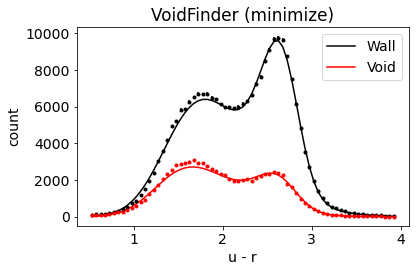

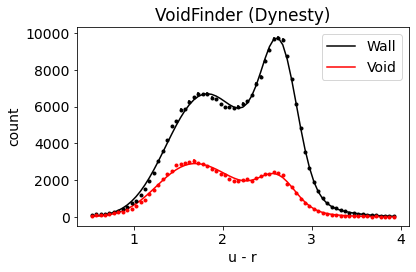

In [98]:
Model_2_plot(VF_ur_bestfit2.x, 
             ur_NSA[wall_vf], 
             ur_NSA[void_vf], 
             ur_bins, 
             2, 
             xlabel_text='u - r', 
             title_text='VoidFinder (minimize)')

Model_2_plot(VF_ur_bestfit2_dynesty, 
             ur_NSA[wall_vf], 
             ur_NSA[void_vf], 
             ur_bins, 
             2, 
             xlabel_text='u - r', 
             title_text='VoidFinder (Dynesty)')

## Bayes Factor

In [87]:
lnB12_V2_ur = lnzM1_V2_ur - lnzM2_V2_ur

B12_V2_ur = np.exp(lnB12_V2_ur)

print('V2 (u - r): B12 = {:.3g}; log(B12) = {:.3g}'.format(B12_V2_ur, np.log10(B12_V2_ur)))

V2 (u - r): B12 = 1.6e-29; log(B12) = -28.8


In [99]:
lnB12_VF_ur = lnzM1_VF_ur - lnzM2_VF_ur

B12_VF_ur = np.exp(lnB12_VF_ur)

print('VoidFinder (u - r): B12 = {:.3g}; log(B12) = {:.3f}'.format(B12_VF_ur, lnB12_VF_ur*np.log10(np.exp(1))))

VoidFinder (u - r): B12 = 0; log(B12) = -1555.761


So both VoidFinder and V$^2$ favor $\mathcal{M}_2$, in which the two data sets come from different parent distributions, although VoidFinder favors it much more than V$^2$.